# Projet

Groupe : Brenton, Maxime

Cours : Mathematical Foundation for Artificial Intelligence

Date : Mercredi 14 Juin

**Table des matières**

- PARTIE I : La mise en œuvre de base du jeu
    - 1.1 Données
    - 1.2 Global Variables Constantes
    - 1.3 Fonctions nécessaires
- Partie II : Algorithms Préliminaires
    - 2.1 Selectionner les coups possibles (Random totalement)
    - 2.2 Minmax (Basique)
    - 2.3 Résultats de Minmax et Minmax Alpha-Beta
    - 2.4 Monte Carlo Tree Search
- Partie III : Analyse du jeu
    - 3.1 Mesurer la relation entre le nombre de coups et la victoire (Fonction score)
    - 3.2 Observer la relation entre la répartition des pièces sur le plateau et le résultat du jeu
    - 3.3 Les influences sur le résultat du jeu

## PARTIE I : La mise en œuvre de base du jeu

### 1.1 Données

- `tracerPlateau(A, possible_steps=None)` : Nous avons changé la fonction `tracerPlateau` pour qu'elle affiche le plateau de jeu avec les coordonnées des cases, on ajoute l'exhibition des coups possible pour le joueur courant. 

- Si `possible_steps` est donné, les coups possibles sont maintenant montrés par des `*` sur le plateau de jeu.

(On va les expliquer dans la suite)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time as ttime # Emmmmm .... C'est parce que j'ai pas envie de changer de nom de variable dans le code ...
import csv

In [3]:
def tracerPlateau(A, possible_steps=None):
    n, m = A.shape
    
    plt.xlim(-0.5, n - 0.5)
    plt.ylim(m - 0.5, -0.5)
    
    plt.xticks(np.arange(-0.5, n - 0.5, 1))
    plt.yticks(np.arange(-0.5, m - 0.5, 1))
    plt.tick_params(which = 'major', labelbottom = False, labelleft = False)
    plt.gca().xaxis.tick_top()

    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))
    plt.gca().xaxis.set_minor_formatter(plt.FormatStrFormatter('%d'))
    plt.gca().yaxis.set_minor_formatter(plt.FormatStrFormatter('%d'))

    plt.tick_params(which = 'minor', top = False, left = False, labeltop = True)
    N = np.array([[i, j] for i in range(n) for j in range(m) if A[i, j] == 1])
    B = np.array([[i, j] for i in range(n) for j in range(m) if A[i, j] == -1])
    
    """
    P est un tableau de coordonnées des points où le joueur peut jouer,
    les valeurs de P sont (les indices des points + 2) dans le tableau A
    Nous ajoutons les indices des points dans le tableau A
    """
    
    if possible_steps:
        for index, step in enumerate(possible_steps):
            plt.scatter(step[1], step[0], marker='*', s = 400,alpha=0.5, c = 'g')
            plt.text(step[1], step[0], index+1, verticalalignment="center", horizontalalignment="center")

    if N.shape[0] > 0:
        plt.scatter(N[:, 1], N[:, 0], marker='o', s = 400, c = 'r')
    if B.shape[0] > 0:
        plt.scatter(B[:, 1], B[:, 0], marker='o', s = 400, c = 'b')
        
    plt.grid()
    plt.show()
        

### 1.2 Global Variables Constantes

In [4]:
DIRECTIONS = np.array([[0, 1], [1, 0], [0, -1], [-1, 0],
                       [1, 1], [1, -1], [-1, 1], [-1, -1]])

DIRECTIONS_4 = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])
# Horizental, Vertical, Diagonal, Anti-diagonal

ALPHA = -np.inf 
BETA = np.inf

CORNER_PLACES = np.array([[0, 0], [0, 7], [7, 0], [7, 7]])
CORNER_NEIGHBORS = np.array([[0, 1], [1, 0], [1, 1],
                             [0, 6], [1, 6], [1, 7],
                             [6, 0], [6, 1], [7, 1],
                             [6, 6], [6, 7], [7, 6]])

### 1.3 Fonctions nécessaires

- `init_plateau()` : initialise le plateau de jeu
- `find_possible_steps(A, c, print_info=False)` : trouve les coups possibles pour un joueur
- `A = update(A, c, step=None, changes=None)` : met à jour le plateau de jeu
- `game_finish(A)` : vérifie si le jeu est terminé
- `print_info(A)` : affiche les informations du jeu

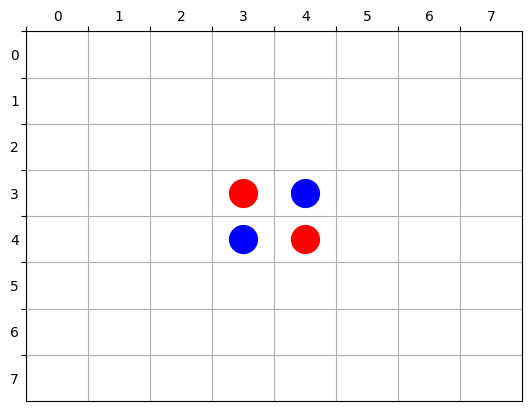

In [5]:
def init_plateau():
    """ 
    Initialise le plateau de jeu
    """ 
    
    A = np.zeros((8, 8), int)
    A[3, 3] = 1
    A[4, 4] = 1
    A[3, 4] = -1
    A[4, 3] = -1
    return A

A = init_plateau()
tracerPlateau(A)

---------Possible Steps---------
Step: [2, 4], Changes: [[3, 4]]
Step: [3, 5], Changes: [[3, 4]]
Step: [4, 2], Changes: [[4, 3]]
Step: [5, 3], Changes: [[4, 3]]
---------Possible Steps---------


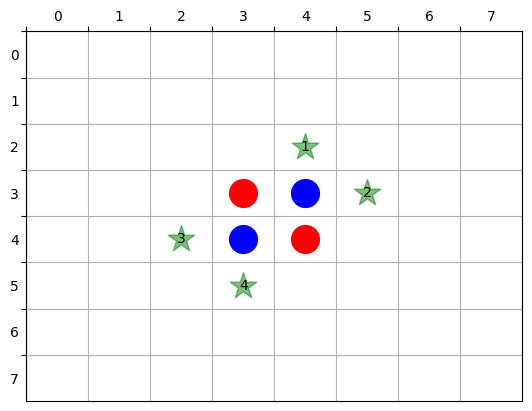

In [6]:
def find_possible_steps(A, c, print_info=False):
    """
    Trouver les coups possibles pour le joueur c
    A, c, print_info -> possible_steps, possible_steps_changes
    
    A : np.array, le plateau
    c : int, le joueur
    print_info : bool, afficher les informations ou non
    """
    
    n, m = A.shape

    possible_steps = []
    possible_steps_changes = []
    
    for i in range(n):
        for j in range(m):
            change_flag = False
            if A[i, j] == 0:
                possible_steps_changes_dir = []
                changes_correspond_list = []
                for step in DIRECTIONS:
                    x, y = i, j # une copy de i, j
                    move = 0

                    
                    x += step[0]
                    y += step[1]
                    
                    while 0 <= x and x < n and 0 <= y and y < m:
                        if A[x, y] == 0:
                            # Si on rencontre un 0, on arrête de chercher dans cette direction
                            break
                        
                        if A[x, y] == c:
                            # Si on rencontre un pion de la même couleur, on ajoute les pions entre les deux pions dans la liste
                            if move > 0:
                                change_flag = True
                                for k in range(1, move + 1):
                                    changes_correspond_list.append([i + k * step[0], j + k * step[1]])
                            break

                        if A[x, y] == -c:
                            # Si on rencontre un pion de la couleur opposée, on continue de chercher
                            x += step[0]
                            y += step[1]
                            move += 1
                            
                        
                if changes_correspond_list:
                    # Si on a trouvé des pions à changer dans cette direction, on ajoute les pions dans la liste
                    possible_steps_changes_dir.append(changes_correspond_list)
                
                if possible_steps_changes_dir:    
                    possible_steps_changes.extend(possible_steps_changes_dir)
                
            if change_flag:
                possible_steps.append([i, j])
                
    if print_info:
        print("---------Possible Steps---------")
        for step, change in zip(possible_steps, possible_steps_changes):
            print(f"Step: {step}, Changes: {change}")
        print("---------Possible Steps---------")
          
    return possible_steps, possible_steps_changes

A = init_plateau()
possible_steps, _ = find_possible_steps(A, c=1, print_info=True)

tracerPlateau(A, possible_steps=possible_steps)
# possible_steps

Les coups possibles sont maintenant montrés par des `*` sur le plateau de jeu, comme nous avons dit dans la fonction `tracerPlateau`.

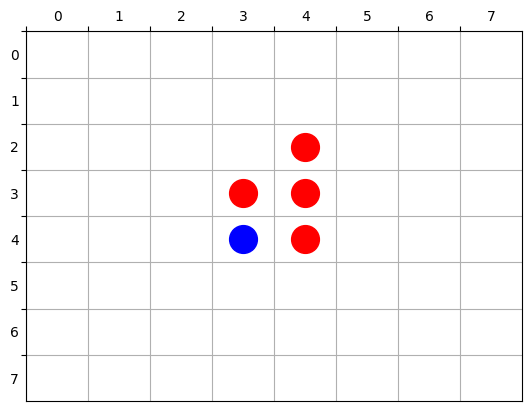

In [7]:
def update(A, c, step=None, changes=None):
    """
    Mettre à jour le plateau A
    A, c, step=None, changes=None -> A
    
    A : np.array, le plateau
    c : int, le joueur
    step : list, le coup
    changes : list, les changements
    """
    
    A = A.copy()
    
    if step:    
        if not changes:
            "If changes are not given in input, we are going to find the corresponding changes"
            possible_steps, possible_steps_changes = find_possible_steps(A, c)
        
            if possible_steps:     
                "If there are possible steps, we are going to check if the step is valid"
                # assert step in possible_steps, "Invalid Step"
                for candidate_step, candidate_change in zip(possible_steps, possible_steps_changes):
                    if candidate_step == step:
                        for change in candidate_change:
                            A[change[0], change[1]] = c
                        A[step[0], step[1]] = c
                        break
            
            "If there are no possible steps, we are going to skip the step"
                

        else:
            "If changes are given, we are going to skip the step check"
            A[step[0], step[1]] = c
            for index, change in enumerate(changes):
                A[change[0], change[1]] = c
                
    """
    Les changements possibles ne sont plus nécessaires, nous allons les supprimer
    """
    A[A > 1] = 0
    
    return A

"""
Nous allons donner deux types de coups possibles
"""

A = init_plateau()                
A = update(A, c=1, step=[2, 4], changes=[[3, 4]]) # Nous donnons les changements pour éviter de les calculer
tracerPlateau(A)

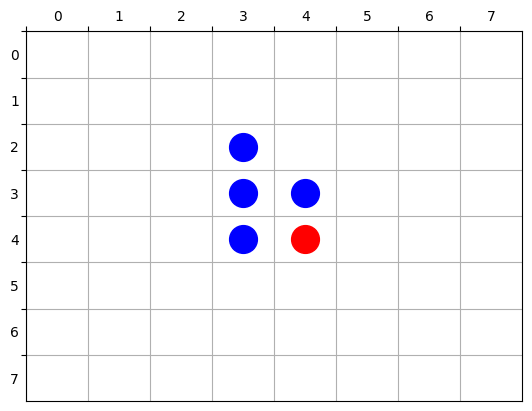

In [8]:
A = init_plateau()
A = update(A, c=-1, step=[2, 3]) 
# Sans les changements donnés, nous allons trouver les changements correspondants nous-mêmes
tracerPlateau(A)

In [9]:
def game_finish(A):
    """
    Vérifier si le jeu est terminé
    A -> game_status
    
    A : np.array, le plateau
    """
    
    game_status = False
    if np.sum(A == 0) == 0:
        game_status = True
    
    if not find_possible_steps(A, c=1)[0] and not find_possible_steps(A, c=-1)[0]:
        game_status = True

    return game_status

A = init_plateau()
game_finish(A)

False

Le résultat : 2 --- 2 


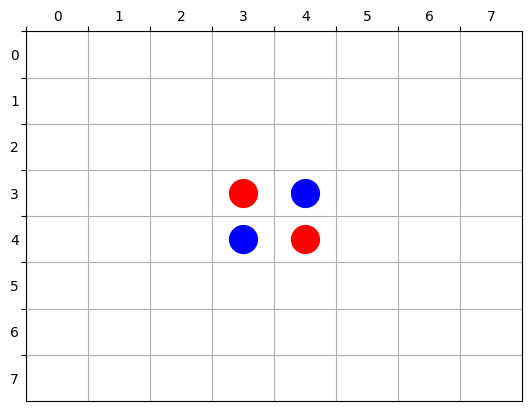

In [10]:
def print_info(A):
    """
    Afficher les informations du jeu
    A -> None
    
    A : np.array, le plateau
    """
    
    print("Le résultat : {} --- {} ".format(np.sum(A == 1), np.sum(A == -1)))
    tracerPlateau(A)

A = init_plateau()
print_info(A)

## Partie II : Algorithms Préliminaires

### 2.1 Selectionner les coups possibles (Random totalement)

- Dans cette partie, nous avons créé une fonction `game_auto_random(A, c, maximum_steps=None)` qui sélectionne un coup possible aléatoirement pour les joueurs. Nous avons utilisé la fonction `find_possible_steps(A, c)` pour trouver les coups possibles pour le joueur `c` et nous avons utilisé la fonction `random.choice()` pour sélectionner un coup aléatoire.

- En même temps, la variable `maximum_steps` est utilisée pour limiter le nombre de coups possibles pour les deux joueurs. Si `maximum_steps` n'est pas donné, il n'y a pas de limite.

Le résultat : 16 --- 12 


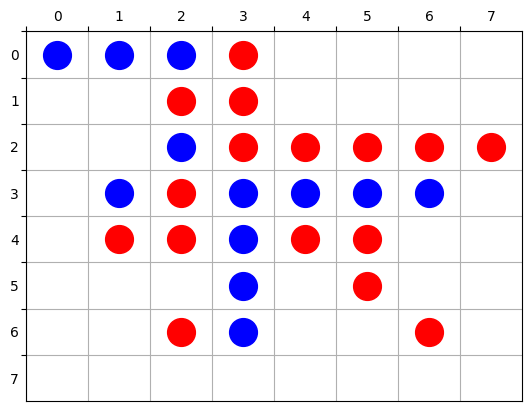

In [11]:
def game_auto_random(A, c, maximum_steps=None):
    """
    Jouer le jeu automatiquement
    A, c, maximum_steps=None -> A
    
    A : np.array, le plateau
    c : int, le joueur
    maximum_steps : int, le nombre de coups maximum
    """
    
    if maximum_steps:
        steps_left = maximum_steps
    else:
        steps_left = 10000 # The number of maximum_steps will not end the while loop, the game will end when there are no possible steps for both players
        
    while not game_finish(A) and steps_left:
        possible_steps, possible_steps_changes = find_possible_steps(A, c)
        steps_left -= 1
        
        if possible_steps:
            step = random.choice(possible_steps)

            A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
            # tracerPlateau(A)
            plt.show()
            c = -c
        else:
            c = -c
    return A
         
A = init_plateau()
print_info(game_auto_random(A, c=1, maximum_steps=24)) # 24 steps is the maximum steps for the game, 12 steps for each player

Le résultat : 43 --- 21 


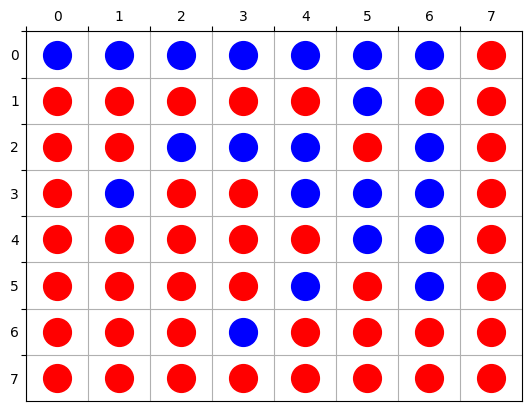

In [12]:
# Cas when maximum_steps is not given
A = init_plateau()
print_info(game_auto_random(A, c=1)) # The game will end when there are no possible steps for both players

Le temps pour finir un jeu totalement aléatoire $\approxeq 40 \text{ ms}$ 

In [13]:
%timeit A = init_plateau(); game_auto_random(A, c=1)

38.7 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 2.2 Minmax (Basique)

Dans cette partie, les fonctions suivantes sont créées :
- `score(A)` : calcule le score du plateau de jeu
    $$
    \boxed{
    \text{score}(A) = \text{nombre de pions de } \text{Joueur 1} - \text{nombre de pions de } \text{Joueur 2}}
    .$$
- `minmax(A, c, depth=3, print_info=False)` : implémente l'algorithme minmax
- `alpha_beta(A, c, depth=3, print_info=False)` : implémente l'algorithme alpha-beta

(Les deux algorithmes créées ici sont utilisées seulement dans cette partie, on va les améliorer dans la partie suivante)

In [14]:
def score(A):
    """
    Calculer le score du jeu, le premier version
    """
    
    return np.sum(A == 1) - np.sum(A == -1)

A = init_plateau()
score(A)

0

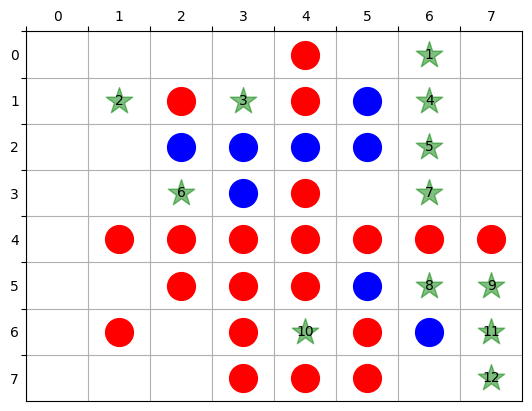

---------Minmax Algorithm---------
Le minmax de depth=3 vous suggeste le coup [0, 6], numéroté 1 avec le score 17
---------Minmax Algorithm---------


In [15]:
def minmax(A, c, depth=3, print_info=False):
    if depth == 0 or game_finish(A):
        return None, score(A)
    
    possible_steps, possible_steps_changes = find_possible_steps(A, c)
    
    if not possible_steps:
        return None, score(A)
    
    score_global = -c * np.inf
    
    for steps, changes in zip(possible_steps, possible_steps_changes):
        A_copy = update(A, c, steps, changes)
        step_next_depth, score_next_depth = minmax(A_copy, -c, depth - 1)
        
        if c==1 and score_next_depth > score_global:
            score_global = score_next_depth
            step = steps
            
        if c==-1 and score_next_depth < score_global:
            score_global = score_next_depth
            step = steps
            
    if print_info:
        print("---------Minmax Algorithm---------")
        print(f"Le minmax de depth={depth} vous suggeste le coup {step}, numéroté {possible_steps.index(step)+1} avec le score {score_global}")
        print("---------Minmax Algorithm---------")

    return step, score_global

"""
Un exemple aléatoire
"""

A = init_plateau()
A = game_auto_random(A, c=1, maximum_steps=24) # Créer un plateau aléatoire, avec 24 coups déjà joués

tracerPlateau(A, find_possible_steps(A, c=1)[0]) # Visualiser les coups possibles pour le joueur 1
_ = minmax(A, 1, depth=3, print_info=True)

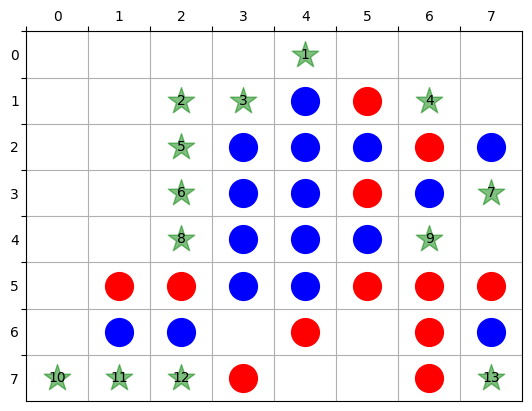

---------Minmax Alpha-Beta Algorithm---------
Le minmax alpha-beta de depth=5 vous suggeste le coup [0, 4], numéroté 1 avec le score 11
---------Minmax Alpha-Beta Algorithm---------


In [16]:
def alpha_beta(A, c, depth, print_info=False):
    global alpha, beta
    if depth == 0 or game_finish(A):
        return None, score(A)
    
    possible_steps, possible_steps_changes = find_possible_steps(A, c)
    if not possible_steps:
        return None, score(A)
    
    score_global = -c * np.inf
    alpha = ALPHA; beta = BETA
    
    for steps, changes in zip(possible_steps, possible_steps_changes):
        A_copy = update(A, c, steps, changes)
        step_next_depth, score_next_depth = alpha_beta(A_copy, -c, depth - 1)
        
        if c==1:
            if score_next_depth > score_global:
                score_global = score_next_depth                 
                step = steps

            if score_global > alpha:
                alpha = score_global
                if alpha >= beta:
                    break
               
        if c==-1:
            if score_next_depth < score_global:
                score_global = score_next_depth
                step = steps
            
            if score_global < beta:
                beta = score_global
                if beta <= alpha:
                    break
    
    if print_info:
        print("---------Minmax Alpha-Beta Algorithm---------")
        print(f"Le minmax alpha-beta de depth={depth} vous suggeste le coup {step}, numéroté {possible_steps.index(step)+1} avec le score {score_global}")
        print("---------Minmax Alpha-Beta Algorithm---------")
            
    return step, score_global

A = init_plateau()
A = game_auto_random(A, c=1, maximum_steps=24) # De même façon

tracerPlateau(A, find_possible_steps(A, c=1)[0])
_ = alpha_beta(A, 1, depth=5, print_info=True)

### 2.3 Résultats de Minmax et Minmax Alpha-Beta

Nous allons tester les algorithms.

#### 2.3a Minmax vs Random
$$
\text{Minmax Alpha-Beta[5]} \text{ vs } \text{Random}
$$

In [17]:
def game_auto_minmax_alpha_beta(A, c, depth=5):
    while not game_finish(A):
        possible_steps, possible_steps_changes = find_possible_steps(A, c)
        
        if c == 1:
            if possible_steps:
                step = alpha_beta(A, c, depth)[0]
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        if c == -1:
            if possible_steps:
                step = random.choice(possible_steps)
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        c = -c
    
    return A

In [19]:
win_rate = 0

for fois in range(100+1):
    A = init_plateau()
    c = 1
    A = game_auto_minmax_alpha_beta(A, c, depth=5)
    if score(A) > 0:
        win_rate += 1
        
    if fois % 20 == 0:
        print(f"Le taux de victoire de l'algorithme minmax alpha-beta est {win_rate}/{fois+1}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/linnan/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/mf/g5y5hwk14_dcz0m06zfvvcbc0000gn/T/ipykernel_80021/2925439890.py", line 6, in <module>
    A = game_auto_minmax_alpha_beta(A, c, depth=5)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/mf/g5y5hwk14_dcz0m06zfvvcbc0000gn/T/ipykernel_80021/3716912159.py", line 7, in game_auto_minmax_alpha_beta
    step = alpha_beta(A, c, depth)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/mf/g5y5hwk14_dcz0m06zfvvcbc0000gn/T/ipykernel_80021/1074035978.py", line 15, in alpha_beta
    step_next_depth, score_next_depth = alpha_beta(A_copy, -c, depth - 1)
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/mf/g5y5hwk14_dcz0m06zfvvcbc0000gn/T/ipykernel_80021/1074035978.py", line 15, in alpha_beta
  

#### 2.3b Le temps pour l'algorithm Minmax et Alpha-Beta 

Nous utilisons la fonction `timeit` pour calculer le temps pour l'algorithm Minmax et Alpha-Beta, après 42 coups déjà faites.

Nous pouvons oberserver que le temps pour l'algorithm Alpha-Beta est un peu plus court que l'algorithm Minmax de même profondeur.

In [120]:
%timeit A = init_plateau(); A = game_auto_random(A, c=1, maximum_steps=42); minmax(A, c=1, depth=3)
%timeit A = init_plateau(); A = game_auto_random(A, c=1, maximum_steps=42); minmax(A, c=1, depth=4)
%timeit A = init_plateau(); A = game_auto_random(A, c=1, maximum_steps=42); minmax(A, c=1, depth=5)

102 ms ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
763 ms ± 312 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 17.85 times longer than the fastest. This could mean that an intermediate result is being cached.
7.4 s ± 6.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit A = init_plateau(); A = game_auto_random(A, c=1, maximum_steps=42); alpha_beta(A, c=1, depth=3)
%timeit A = init_plateau(); A = game_auto_random(A, c=1, maximum_steps=42); alpha_beta(A, c=1, depth=4)
%timeit A = init_plateau(); A = game_auto_random(A, c=1, maximum_steps=42); alpha_beta(A, c=1, depth=5)
%timeit A = init_plateau(); A = game_auto_random(A, c=1, maximum_steps=42); alpha_beta(A, c=1, depth=6)
%timeit A = init_plateau(); A = game_auto_random(A, c=1, maximum_steps=42); alpha_beta(A, c=1, depth=7)

38.9 ms ± 6.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.7 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
158 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 5.79 times longer than the fastest. This could mean that an intermediate result is being cached.
796 ms ± 358 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 5.04 times longer than the fastest. This could mean that an intermediate result is being cached.
4.85 s ± 2.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2.4 Monte Carlo Tree Search

https://www.zhihu.com/question/39916945
SELECTION

The idea is to keep selecting best child nodes until we reach the leaf node of the tree. A good way to select such a child node is to use UCT (Upper Confidence Bound applied to trees) formula:

	wi/ni + c*sqrt(t)/ni
wi = number of wins after the i-th move
ni = number of simulations after the i-th move
c = exploration parameter (theoretically equal to √2)
t = total number of simulations for the parent node

EXPANSION:

When it can no longer apply UCT to find the successor node, it expands the game tree by appending all possible states from the leaf node.

SIMULATION:

After Expansion, the algorithm picks a child node arbitrarily, and it simulates entire game from selected node until it reaches the resulting state of the game. If nodes are picked randomly during the play out, it is called light play out. You can also opt for heavy play out by writing quality heuristics or evaluation functions.

BACKPROPAGATION:

Once the algorithm reaches the end of the game, it evaluates the state to figure out which player has won. It traverses upwards to the root and increments visit score for all visited nodes. It also updates win score for each node if the player for that position has won the playout.

In [121]:
TIME_LIMIT = 2
UCT_C = 1.414
UCT_FUNC = lambda w_i, n_i, n: w_i / n_i + UCT_C * np.sqrt(np.log(n) / n_i)

In [122]:
UCT_FUNC(1, 1, 1)

1.0

In [123]:
class Node():
    def __init__(self, parent, c):
        self.parent = parent
        self.wins = 0
        self.num_sim = 0
        self.c = c # color
        self.children = dict()
    
    """    
    def __init__(self, parent, color):
        self.parent = parent
        self.w = 0
        self.n = 0
        self.color = color
        self.child = dict()
    """   

In [124]:
def select(root_node, A):
    """
    Select the leaf node to expand
    """
    B = A.copy()
    
    if len(root_node.children) == 0:
        return root_node 
    
    else:
        score_max = 0
        step_best = None
        
        for step in root_node.children.keys():
            step = tuple(step)
            if root_node.children[step].num_sim == 0:
                """
                If the node has not been visited, we select it
                """
                step_best = step
                break
                
            else:
                score_of_the_step = UCT_FUNC(root_node.children[step].wins, 
                                             root_node.children[step].num_sim,
                                             root_node.num_sim)
                
                # print(f"score_max: {score_max}, score_of_the_step: {score_of_the_step}")
                if not score_max or score_of_the_step > score_max:
                    score_max = score_of_the_step
                    step_best = step 
                    
        # print(f"root_node.children: {root_node.children}")
        
        # print(f"step_best: {step_best}, root_node_color: {root_node.c}, B: {B}")
        B = update(B, root_node.c, step_best)
        return select(root_node.children[step_best], B) # ???
        return step_best

In [130]:
def expand(root_node, A):
    """
    Expand the leaf node
    """ 
    
    # print(A, root_node.c)
    A = A.copy()
    possible_steps, _ = find_possible_steps(A, root_node.c)
    for step in possible_steps:
        step = tuple(step)
        root_node.children[step] = Node(root_node, -root_node.c)

In [125]:
def simulate(root_node, A):
    """ 
    Simulate the game
    """
    B = np.copy(A)
    # print(B, root_node.parent, root_node.c)
    # B = update(B, root_node.parent, root_node.c)
    C = game_auto_random(B, -root_node.c)
    
    return C

In [126]:
def backpropagation(root_node, result):
    """
    Backpropagation
    """
    
    root_node.num_sim += 1
    root_node.wins += result
    
    if root_node.parent is not None:
        backpropagation(root_node.parent, -result)

In [127]:
def mcts(A, c=1, time_limit=2):
    root = Node(parent=None, c=c)
    
    time_begin = ttime.time()
    
    while ttime.time() - time_begin < time_limit:
        B = A.copy()
        step = select(root, B)
        # print(f"select finished.")
        
        expand(step, B)
        # print(f"expand finished.")
        
        result_plateau = simulate(step, B)
        # print(f"simulate finished.")
        if score(result_plateau) > 0:
            win_c = 1
        elif score(result_plateau) < 0:
            win_c = -1
        else:
            win_c = 0
        
        backpropagation(step, win_c)
        
    num_sim_best = None
    step_best = None 
    
    for step, node in root.children.items():
        if num_sim_best is None or node.num_sim > num_sim_best:
            num_sim_best = node.num_sim
            step_best = step

    return step_best

Le résultat : 2 --- 2 


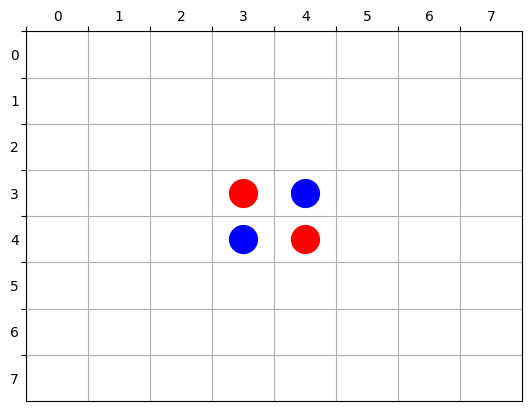

(5, 3)

In [131]:
A = init_plateau()
print_info(A)
mcts(A, c=1, time_limit=6)

Le résultat : 26 --- 38 


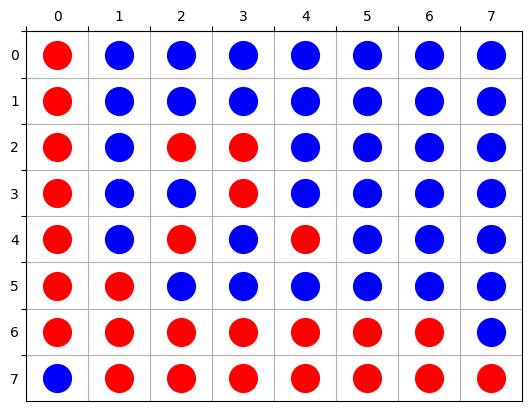

In [133]:
A = init_plateau()
c = 1

while not game_finish(A):
    possible_steps, possible_steps_changes = find_possible_steps(A, c)
    
    if c == 1:
        if possible_steps:
            step = mcts(A, c, time_limit=3)
            step = list(step)
            A = update(A, c, step)
            
    if c == -1:
        if possible_steps:
            step = random.choice(possible_steps)
            A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
    
    c = -c
    
print_info(A)

## Partie III : Analyse du jeu

### 3.1 : Mesurer la relation entre le nombre de coups et la victoire (Fonction score)

La partie suivante est pour mesurer la relation entre le nombre de coups et la victoire. Nous déssinerons le graphique de la relation entre le nombre de coups pendant le jeu, les couleurs rouge et bleu représentent les cas où le joueur 1 et 2 gagne respectivement.

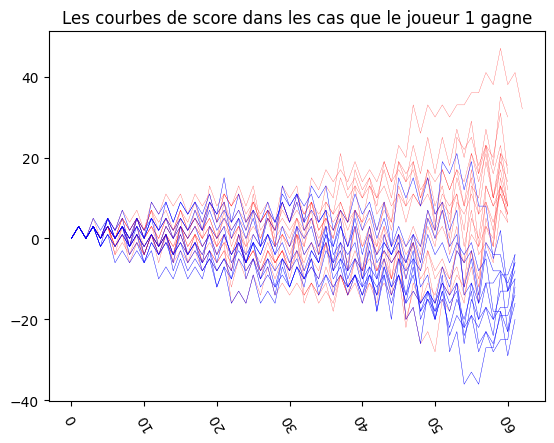

In [134]:
score_list1 = []
score_list2 = []

for fois in range(100):
    A = init_plateau(); c = 1
    score_list_temp = []
    while not game_finish(A):
        possible_steps, possible_steps_changes = find_possible_steps(A, c)
        score_list_temp.append(score(A))
        
        if possible_steps:
            step = random.choice(possible_steps)

            A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
            c = -c 
        else:
            c = -c
    
    score_list_temp.append(score(A))
    if score_list_temp[-1] > 0 and c == 1:
        score_list1.append(score_list_temp)
        
    if score_list_temp[-1] < 0 and c == -1:
        score_list2.append(score_list_temp)

# plt.boxplot(score_list1)
for score_fois in score_list1:
    plt.plot(score_fois, color="red", alpha=0.8, linewidth=0.2)
    
for score_fois in score_list2:
    plt.plot(score_fois, color="blue", alpha=1, linewidth=0.3)

plt.xticks(rotation=120)
_ = plt.title("Les courbes de score dans les cas que le joueur 1 gagne")

### 3.2 : Observer la relation entre la répartition des pièces sur le plateau et le résultat du jeu

Nous avons supposé que les pièces sur différentes positions ont des impacts différents sur le jeu. Ainsi, nous avons observé de nombreux ensembles de données pour déterminer les différences entre les positions en ce qui concerne les résultats du jeu.

In [ ]:
"""
La partie suivante est pour la création de la base de données.
"""

"""
plateau_count1 = np.zeros_like(A)

for fois in range(5000):
    A = init_plateau()
    A = game_auto_random(A, c=1)
    A = np.array(A)
    
    if score(A) > 0:
        for i in range(8):
            for j in range(8):
                if A[i,j] == 1:
                    plateau_count1[i,j] = plateau_count1[i,j]+1
    if score(A) < 0:
        for i in range(8):
            for j in range(8):
                if A[i,j] == 1:
                    plateau_count1[i,j] = plateau_count1[i,j]-1

plateau_count2 = np.zeros_like(A)

for fois in range(5000):
    A = init_plateau()
    A = game_auto_random(A, c=-1)
    A = np.array(A)
    
    if score(A) < 0:
        for i in range(8):
            for j in range(8):
                if A[i,j] == -1:
                    plateau_count2[i,j] = plateau_count2[i,j]+1
    if score(A) > 0:
        for i in range(8):
            for j in range(8):
                if A[i,j] == -1:
                    plateau_count2[i,j] = plateau_count2[i,j]-1

with open('plateau_count1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in plateau_count1:
        writer.writerow(row)

with open('plateau_count2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in plateau_count2:
        writer.writerow(row)                    
"""

print("Les résultats sont dans le fichier 'plateau_count1.csv' et 'plateau_count2.csv'")

Les résultats sont dans le fichier 'plateau_count1.csv' et 'plateau_count2.csv'


In [135]:
plateau_count1 = []
plateau_count2 = []

with open('plateau_count1.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        plateau_count1.append(row)
    for i in range(8):
        for j in range(8):
            plateau_count1[i][j] = int(plateau_count1[i][j])
    plateau_count1 = np.array(plateau_count1)

with open('plateau_count2.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        plateau_count2.append(row)
    for i in range(8):
        for j in range(8):
            plateau_count2[i][j] = int(plateau_count2[i][j])
    plateau_count2 = np.array(plateau_count2)

plateau_count1 , plateau_count2

(array([[520, 692, 758, 804, 817, 765, 726, 649],
        [667, 536, 205, 215, 225, 234, 542, 728],
        [746, 209, 279, 123, 141, 384, 247, 768],
        [753, 211, 180, 221, 202, 132, 251, 809],
        [757, 208, 165, 287, 257,  89, 278, 810],
        [760, 291, 413, 158, 100, 336, 235, 767],
        [676, 598, 262, 250, 210, 220, 544, 685],
        [602, 730, 776, 791, 782, 732, 681, 554]]),
 array([[713, 780, 787, 805, 808, 793, 690, 581],
        [791, 628, 264, 218, 233, 271, 543, 680],
        [880, 301, 390, 152, 179, 384, 262, 736],
        [925, 274, 182, 334, 384, 156, 226, 779],
        [918, 255, 142, 315, 343, 187, 189, 777],
        [877, 330, 399, 161, 144, 373, 289, 727],
        [820, 683, 309, 319, 293, 314, 571, 688],
        [669, 726, 773, 819, 829, 778, 700, 596]]))

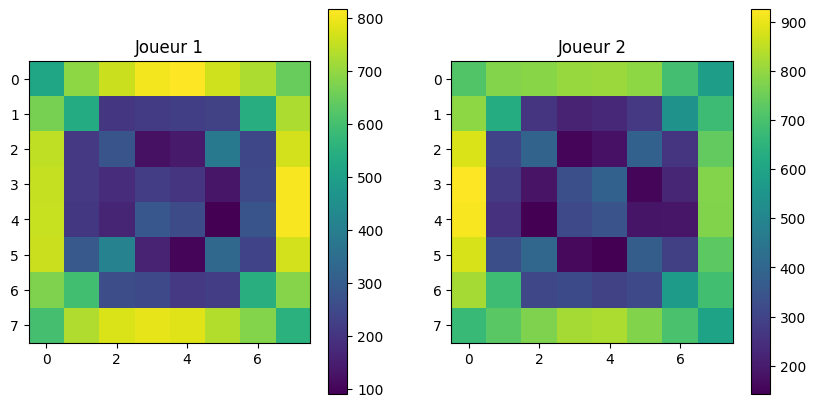

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(plateau_count1, interpolation='nearest')
axs[0].set_title('Joueur 1')
axs[1].imshow(plateau_count2, interpolation='nearest')
axs[1].set_title('Joueur 2')
plt.colorbar(plt.imshow(plateau_count1, interpolation='nearest'), ax=axs[0])
plt.colorbar(plt.imshow(plateau_count2, interpolation='nearest'), ax=axs[1])
plt.show()

### 3.2b : Application du résultat de partie précédente

Selon nos observations, nous avons constaté que certaines cases ont une influence nettement plus importante sur le taux de victoire. Par conséquent, nous avons décidé d'ajouter une pondération à chaque case en fonction du ratio d'influence sur le taux de victoire par rapport à la fonction de score existante. Ainsi, nous effectuons une somme pondérée pour chaque case en utilisant cette approche.

En même temps, nous avons également constaté que les cases différaient légèrement en termes d'influence sur le taux de victoire en fonction du joueur qui joue en premier. Par conséquent, nous avons distingué deux fonctions distinctes pour tenir compte de cette différence.

- `score1(A)`, `score2(A)`

In [137]:
weigh1 = plateau_count1/np.max(plateau_count1)
weigh2 = plateau_count2/np.max(plateau_count2)
weigh1, weigh2

(array([[0.63647491, 0.84700122, 0.92778458, 0.98408813, 1.        ,
         0.93635251, 0.88861689, 0.79436965],
        [0.81640147, 0.65605875, 0.25091799, 0.26315789, 0.2753978 ,
         0.28641371, 0.66340269, 0.89106487],
        [0.9130967 , 0.25581395, 0.34149327, 0.1505508 , 0.17258262,
         0.47001224, 0.30232558, 0.94002448],
        [0.92166463, 0.25826193, 0.22031824, 0.27050184, 0.24724602,
         0.16156671, 0.30722154, 0.99020808],
        [0.92656059, 0.25458996, 0.20195838, 0.35128519, 0.31456548,
         0.10893513, 0.34026928, 0.99143207],
        [0.93023256, 0.35618115, 0.50550796, 0.19339045, 0.12239902,
         0.41126071, 0.2876377 , 0.93880049],
        [0.82741738, 0.73194614, 0.32068543, 0.30599755, 0.25703794,
         0.26927785, 0.66585067, 0.83843329],
        [0.73684211, 0.89351285, 0.9498164 , 0.96817625, 0.95716034,
         0.89596083, 0.83353733, 0.67809058]]),
 array([[0.77081081, 0.84324324, 0.85081081, 0.87027027, 0.87351351,
         

In [138]:
def score1(A):
    
    weigh1 = plateau_count1/np.max(plateau_count1)
    
    score = 0
    for i in range(8):
        for j in range(8):
            score += weigh1[i,j]*A[i,j] # On ajoute les poids des cases occupées par le joueur 1
    return score
    
def score2(A):
    weigh2 = plateau_count2/np.max(plateau_count2)
    
    score = 0
    for i in range(8):
        for j in range(8):
            score += weigh2[i,j]*A[i,j] # On ajoute les poids des cases occupées par le joueur 2
    return score


In [139]:
def minmax(A, c, depth, score_method1=score1, score_method2=score2): 
    # Par défaut, nous utilisons les deux fonctions définies précédemment telles qu'elles.
    if depth == 0 or game_finish(A):
        if c == 1:
            return None, score_method1(A)
        if c == -1:
            return None, score_method2(A)
    
    possible_steps, possible_steps_changes = find_possible_steps(A, c)
    
    if not possible_steps:
        if c == 1:
            return None, score_method1(A)
        if c == -1:
            return None, score_method2(A)
    
    score_global = -c * np.inf
    
    for steps, changes in zip(possible_steps, possible_steps_changes):
        A_copy = update(A, c, steps, changes)
        step_next_depth, score_next_depth = minmax(A_copy, -c, depth - 1)
        
        if c==1 and score_next_depth > score_global:
            score_global = score_next_depth
            step = steps
            
        if c==-1 and score_next_depth < score_global:
            score_global = score_next_depth
            step = steps
    
    return step, score_global

A = init_plateau()
minmax(A, 1, 5)

([4, 2], 1.2648648648648644)

In [140]:
def alpha_beta(A, c, depth, score_method1=score1, score_method2=score2):
    global alpha, beta
    if depth == 0 or game_finish(A):
        if c == 1:
            return None, score_method1(A)
        if c == -1:
            return None, score_method2(A)
    
    possible_steps, possible_steps_changes = find_possible_steps(A, c)
    if not possible_steps:
        if c == 1:
            return None, score_method1(A)
        if c == -1:
            return None, score_method2(A)
    
    score_global = -c * np.inf
    alpha = ALPHA; beta = BETA
    
    for steps, changes in zip(possible_steps, possible_steps_changes):
        A_copy = update(A, c, steps, changes)
        step_next_depth, score_next_depth = alpha_beta(A_copy, -c, depth - 1)
        
        if c==1:
            if score_next_depth > score_global:
                score_global = score_next_depth                 
                step = steps

            if score_global > alpha:
                alpha = score_global
                if alpha >= beta:
                    break
               
        if c==-1:
            if score_next_depth < score_global:
                score_global = score_next_depth
                step = steps
            
            if score_global < beta:
                beta = score_global
                if beta <= alpha:
                    break
            
    return step, score_global

A = init_plateau()
alpha_beta(A, 1, 5)

([4, 2], 1.7632432432432432)

Le résultat : 56 --- 7 


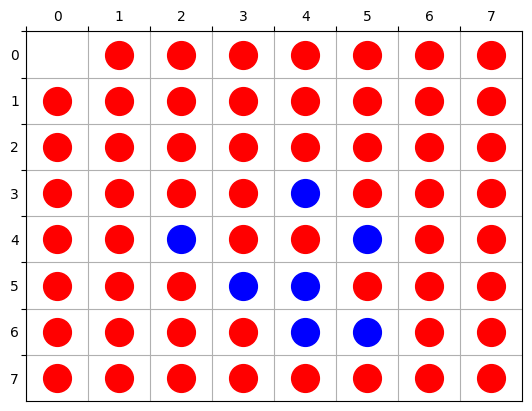

In [141]:
A = init_plateau()
c = 1

while not game_finish(A):
    possible_steps, possible_steps_changes = find_possible_steps(A, c)
    
    if c == 1:
        if possible_steps:
            step = alpha_beta(A, c, depth=5, score_method1=score1, score_method2=score2)[0]
            A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
            plt.show()
    if c == -1:
        if possible_steps:
            step = random.choice(possible_steps)
            A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
            plt.show()
    c = -c

print_info(A)

### 3.2c : Résultat

In [ ]:
def game_auto_minmax_alpha_beta(A, c, depth=5):
    while not game_finish(A):
        possible_steps, possible_steps_changes = find_possible_steps(A, c)
        
        if c == 1:
            if possible_steps:
                step = alpha_beta(A, c, depth, score_method1=score1, score_method2=score2)[0]
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        if c == -1:
            if possible_steps:
                step = random.choice(possible_steps)
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        c = -c
    
    return A

win_rate = 0

for fois in range(100+1):
    A = init_plateau()
    c = 1
    A = game_auto_minmax_alpha_beta(A, c, depth=5)
    if score(A) > 0:
        win_rate += 1
        
    if fois % 20 == 0:
        print(f"Le taux de victoire de l'algorithme minmax alpha-beta est {win_rate}/{fois+1}")

Le taux de victoire de l'algorithme minmax alpha-beta est 1/1
Le taux de victoire de l'algorithme minmax alpha-beta est 16/21
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/linnan/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/mf/g5y5hwk14_dcz0m06zfvvcbc0000gn/T/ipykernel_62069/4032048407.py", line 24, in <module>
    A = game_auto_minmax_alpha_beta(A, c, depth=5)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/mf/g5y5hwk14_dcz0m06zfvvcbc0000gn/T/ipykernel_62069/4032048407.py", line 7, in game_auto_minmax_alpha_beta
    step = alpha_beta(A, c, depth, score_method1=score1, score_method2=score2)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/mf/g5y5hwk14_dcz0m06zfvvcbc0000gn/T/ipykernel_62069/2363464609.py", line 21, in alpha_beta
    step_next_depth, score_next_depth = alpha_beta(A_copy, -c, depth - 1)
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/mf/g

### 3.2d : Score : Normalisation ?

D'après nos hypothèses, nous avons supposé que la normalisation pourrait améliorer les résultats. Cependant, les résultats des expérimentations ont montré que l'effet était minime.

In [142]:
weigh1 = (plateau_count1 - np.min(plateau_count1))/(np.max(plateau_count1) - np.min(plateau_count1))
weigh1

array([[0.59203297, 0.8282967 , 0.91895604, 0.98214286, 1.        ,
        0.92857143, 0.875     , 0.76923077],
       [0.79395604, 0.61401099, 0.15934066, 0.17307692, 0.18681319,
        0.19917582, 0.62225275, 0.87774725],
       [0.90247253, 0.16483516, 0.26098901, 0.0467033 , 0.07142857,
        0.40521978, 0.21703297, 0.93269231],
       [0.91208791, 0.16758242, 0.125     , 0.18131868, 0.15521978,
        0.05906593, 0.22252747, 0.98901099],
       [0.91758242, 0.16346154, 0.1043956 , 0.27197802, 0.23076923,
        0.        , 0.25961538, 0.99038462],
       [0.9217033 , 0.27747253, 0.44505495, 0.09478022, 0.01510989,
        0.33928571, 0.20054945, 0.93131868],
       [0.80631868, 0.69917582, 0.23763736, 0.22115385, 0.16620879,
        0.17994505, 0.625     , 0.81868132],
       [0.70467033, 0.88049451, 0.94368132, 0.96428571, 0.95192308,
        0.88324176, 0.81318681, 0.63873626]])

In [143]:
def score1_norm(A):
    plateau_count1 = np.array(plateau_count1)
    weigh1 = (plateau_count1 - np.min(plateau_count1)) / (np.max(plateau_count1) - np.min(plateau_count1))
    
    score1_norm_tot = 0
    for i in range(8):
        for j in range(8):
            score1_norm_tot += weigh1[i,j]*A[i,j]
    return score1_norm_tot

def score2_norm(A):
    plateau_count2 = np.array(plateau_count2)
    weigh2 = (plateau_count2 - np.min(plateau_count2)) / (np.max(plateau_count2) - np.min(plateau_count2))
    
    score2_norm_tot = 0
    for i in range(8):
        for j in range(8):
            score2_norm_tot += weigh2[i,j]*A[i,j]
    return score1_norm_tot

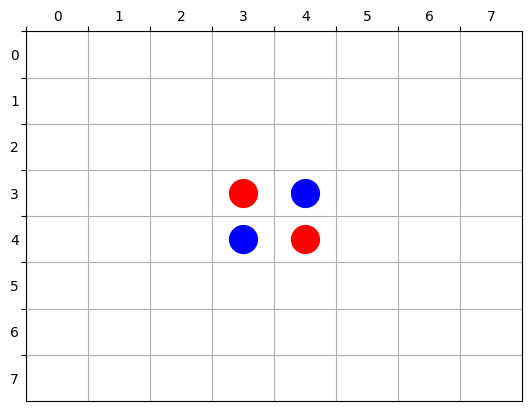

([4, 2], 1.7632432432432432)

In [144]:
A = init_plateau()
tracerPlateau(A)
alpha_beta(A, 1, 5, score_method1=score1_norm, score_method2=score2_norm)

### 3.2e : Résultat-Normalisation

Le résultat : 43 --- 21 


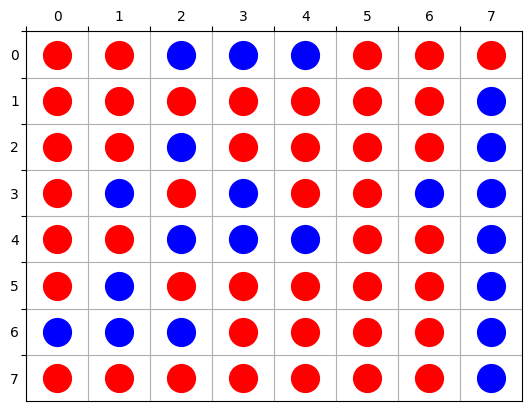

In [147]:
A = init_plateau()
c = 1

while not game_finish(A):
    possible_steps, possible_steps_changes = find_possible_steps(A, c)
    
    if c == 1:
        if possible_steps:
            step = alpha_beta(A, c, depth=5, score_method1=score1_norm, score_method2=score2_norm)[0]
            A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
            plt.show()
    if c == -1:
        if possible_steps:
            step = random.choice(possible_steps)
            A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
            plt.show()
    c = -c
    
print_info(A)

Nous avons testé les résultats en faisant jouer l'IA dans les rôles du joueur qui joue en premier et du joueur qui joue en second.

In [ ]:
win = 0; loss = 0

for fois in range(50):
    A = init_plateau()
    c = 1

    while not game_finish(A):
        possible_steps, possible_steps_changes = find_possible_steps(A, c)
        
        if c == 1:
            if possible_steps:
                step = alpha_beta(A, c, depth=5)[0] # Jouer en premier
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        if c == -1:
            if possible_steps:
                step = random.choice(possible_steps)
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        c = -c
        
    if score(A) > 0:
        win += 1
    
    if score(A) < 0:
        loss += 1
        
print(f"win: {win}, loss: {loss}")

win: 41, loss: 6


In [ ]:
win = 0; loss = 0

for fois in range(50):
    A = init_plateau()
    c = 1

    while not game_finish(A):
        possible_steps, possible_steps_changes = find_possible_steps(A, c)
        
        if c == 1:
            if possible_steps:
                step = random.choice(possible_steps)

                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        if c == -1:
            if possible_steps:
                step = alpha_beta(A, c, depth=5)[0] # Jouer en second
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        c = -c
        
    if score(A) > 0:
        loss += 1
    
    if score(A) < 0:
        win += 1
        
print(f"win: {win}, loss: {loss}")

win: 8, loss: 42


### 3.3 : Les influences sur le résultat du jeu

In [ ]:
"""
A45 = []
A60 = []
Fois = 500

for fois in range(Fois):
    A = init_plateau()
    A = game_auto_random(A, 1, maximum_steps=45)
    A45_list = A.flatten().tolist()
    A45.append(A45_list)
    A = game_auto_random(A, 1)
    A60_list = A.flatten().tolist()
    A60.append(A60_list)

for fois in range(Fois):
    A = init_plateau()
    A = game_auto_random(A, -1, maximum_steps=45)
    A45_list = A.flatten().tolist()
    A45.append(A45_list)
    A = game_auto_random(A, -1)
    A60_list = A.flatten().tolist()
    A60.append(A60_list)

A45 = np.array(A45)
A60 = np.array(A60)

with open('A45.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in A45:
        writer.writerow(row)

with open('A60.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in A60:
        writer.writerow(row)
"""

In [27]:
A45 = []
A60 = []
Fois = 500
with open('A45.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        A45.append(row)
    for i in range(2*Fois):
        for j in range(64):
            A45[i][j] = int(A45[i][j])
    A45 = np.array(A45)

with open('A60.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        A60.append(row)
    for i in range(2*Fois):
        for j in range(64):
            A60[i][j] = int(A60[i][j])
    A60 = np.array(A60)
    
List_A45 = []
List_A60 = []

for i in range(2*Fois):
    List_A45.append(A45[i].reshape(8,8))
for i in range(2*Fois):
    List_A60.append(A60[i].reshape(8,8))
    
List_A45, List_A60

([array([[-1,  0,  1,  1,  1,  1,  0,  0],
         [ 0, -1,  1, -1,  1,  1,  0,  1],
         [ 1, -1, -1,  1, -1, -1,  1,  1],
         [ 0, -1,  1, -1,  1,  1,  1,  1],
         [-1, -1, -1,  1,  1,  1,  1,  1],
         [ 1, -1, -1,  1,  1, -1,  1,  1],
         [ 0,  0, -1,  1,  0,  1,  1,  0],
         [ 0, -1,  0,  0,  1,  0,  1,  0]]),
  array([[ 0,  0, -1, -1, -1,  0, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1],
         [ 0,  0,  0,  1, -1,  1,  1, -1],
         [ 0,  1,  0,  1,  1,  1,  1, -1],
         [-1,  1,  1,  1,  1, -1,  1, -1],
         [ 0,  1,  0,  1, -1,  1,  1, -1],
         [ 1,  0,  1,  1,  1,  1,  1, -1],
         [ 0,  0, -1,  0,  0,  1, -1, -1]]),
  array([[ 1,  1,  1,  0,  0, -1,  0,  0],
         [ 1,  1,  1,  1,  1,  1,  0,  0],
         [ 1,  1,  1, -1,  1,  0,  0,  0],
         [-1, -1, -1, -1,  1,  0,  1,  0],
         [-1, -1,  1, -1, -1,  1, -1, -1],
         [-1,  1, -1, -1,  1,  1, -1,  1],
         [-1, -1, -1,  1, -1, -1,  0,  0],
       

Le résultat : 32 --- 17 


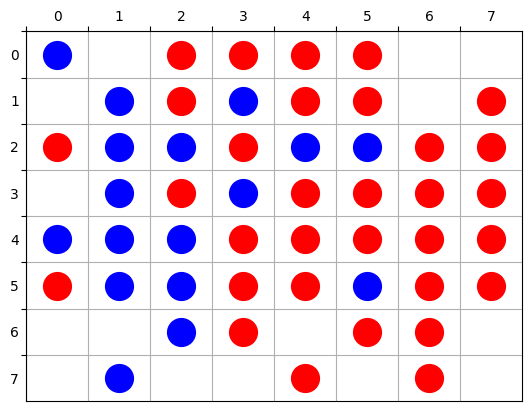

In [28]:
print_info(List_A45[0])

In [29]:
def count_stable1(B, c): 
    stable_count = 0
    status_point = CORNER_PLACES
    for index, corner_place in enumerate(CORNER_PLACES):
        if B[corner_place[0], corner_place[1]] == c:
            stable_count += 1
                    
        elif B[corner_place[0], corner_place[1]] == -c:
            stable_count -= 1
            
    return stable_count

def count_stable2(B, c): 
    stable_count = 0
    status_point = CORNER_NEIGHBORS
    for index, corner_place in enumerate(CORNER_NEIGHBORS):
        if B[corner_place[0], corner_place[1]] == c:
            stable_count += 1
                    
        elif B[corner_place[0], corner_place[1]] == -c:
            stable_count -= 1
            
    return stable_count

In [31]:
A = List_A45[0]

def collect_info(A):
    possible_steps, possible_steps_changes = find_possible_steps(A, 1)

    steps_info = []; c=1

    for step in possible_steps:
        step_status = dict(); 
        step_status["position"] = step
        stable_count = 0
        win_time = 0
        
        B = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
        
        """
        score est le nombre de pions de la couleur c après le coup
        """ 

        step_status["score_change"] = score(B) 
        
        step_status["stable_difference_change"] = count_stable1(B, c) 
        
        step_status["stable_difference_change_2"] = count_stable2(B, c)
        
        possible_steps_opp, _ = find_possible_steps(B, -1)
        step_status["mobility_of_opp"] = len(possible_steps_opp)
        
        C = update(B, -1, minmax(B, -1, depth=1)[0])
        step_status["score_changes_2_steps"] = (np.sum(C == 1) - np.sum(C == -1)) 
        
        possible_steps_2, _ = find_possible_steps(C, -1)
        step_status["mobility_2"] = len(possible_steps_2)
        
        for fois in range(100):
            E = game_auto_random(A, 1)
            if np.sum(E == 1) > np.sum(E == -1):
                win_time += 1

            win_rate_before = win_time / 100

        win_time = 0
        for fois in range(100):
            D = game_auto_random(B, -1)
            if np.sum(D == 1) > np.sum(D == -1):
                win_time += 1

            win_rate_after = win_time / 100
        
        step_status["win rate_change"] = win_rate_after - win_rate_before
        steps_info.append(step_status)
        
    return steps_info
        
collect_info(List_A45[0])

[{'position': [1, 0],
  'score_change': 20,
  'stable_difference_change': -1,
  'stable_difference_change_2': 4,
  'mobility_of_opp': 9,
  'score_changes_2_steps': 15,
  'mobility_2': 8,
  'win rate_change': 0.0},
 {'position': [1, 6],
  'score_change': 18,
  'stable_difference_change': -1,
  'stable_difference_change_2': 2,
  'mobility_of_opp': 7,
  'score_changes_2_steps': 9,
  'mobility_2': 8,
  'win rate_change': -0.010000000000000009},
 {'position': [3, 0],
  'score_change': 26,
  'stable_difference_change': -1,
  'stable_difference_change_2': 1,
  'mobility_of_opp': 7,
  'score_changes_2_steps': 19,
  'mobility_2': 9,
  'win rate_change': -0.07},
 {'position': [6, 0],
  'score_change': 24,
  'stable_difference_change': -1,
  'stable_difference_change_2': 2,
  'mobility_of_opp': 7,
  'score_changes_2_steps': 19,
  'mobility_2': 7,
  'win rate_change': -0.09000000000000002},
 {'position': [6, 1],
  'score_change': 20,
  'stable_difference_change': -1,
  'stable_difference_change_2'

In [32]:
""" 
Training of train_lda1
""" 
step_infos_tot = []
for fois in range(100):
    if fois % 20 == 0:
        print(f"Nous avons fait {fois}/100 fois.")
        
    step_infos_tot.append(collect_info(List_A45[fois]))
    

Nous avons fait 0/100 fois.
Nous avons fait 20/100 fois.
Nous avons fait 40/100 fois.
Nous avons fait 60/100 fois.
Nous avons fait 80/100 fois.


In [110]:
""" 
Training of train_lda2
"""

step_infos_tot2 = []
for fois in range(501, 501+100):
    if fois % 20 == 0:
        print(f"Nous avons fait {fois}/100 fois.")
        
    step_infos_tot2.append(collect_info(List_A45[fois]))

Nous avons fait 520/100 fois.
Nous avons fait 540/100 fois.
Nous avons fait 560/100 fois.
Nous avons fait 580/100 fois.
Nous avons fait 600/100 fois.


In [33]:
""" 
Training of train_lda1
""" 

step_infos_x_reshaped = []; step_infos_y_reshaped = []
for one_game_steps in step_infos_tot:
    for step_info in one_game_steps:
        step_info_x_reshaped22 = []
        step_info_x_reshaped22.append(step_info["score_change"])
        step_info_x_reshaped222.append(step_info["stable_difference_change"])
        step_info_x_reshaped2.append(step_info["stable_difference_change_2"])
        step_info_x_reshaped2.append(step_info["mobility_of_opp"])
        step_info_x_reshaped2.append(step_info["score_changes_2_steps"])
        step_info_x_reshaped2.append(step_info["mobility_2"])
        
        step_infos_y_reshaped.append(step_info["win rate_change"])

    
        step_infos_x_reshaped.append(step_info_x_reshaped2)
        
step_infos_x_reshaped

[[20, -1, 4, 9, 15, 8],
 [18, -1, 2, 7, 9, 8],
 [26, -1, 1, 7, 19, 9],
 [24, -1, 2, 7, 19, 7],
 [20, -1, 2, 9, 11, 10],
 [18, -1, 1, 7, 9, 5],
 [22, -1, 1, 8, 11, 7],
 [2, -2, -4, 9, -19, 5],
 [4, -2, -5, 7, -17, 4],
 [8, 0, 2, 8, -7, 9],
 [4, 0, 2, 7, -7, 7],
 [8, 0, 3, 9, -9, 8],
 [2, 0, 3, 8, -3, 7],
 [8, 0, 3, 9, -5, 9],
 [-8, -2, 3, 7, -21, 6],
 [0, -2, 4, 9, -13, 8],
 [-2, -2, 3, 6, -15, 5],
 [-8, -2, 3, 9, -21, 8],
 [-6, -2, 3, 9, -19, 8],
 [6, -2, 3, 9, -7, 9],
 [2, -2, 3, 6, -11, 7],
 [-4, -2, 6, 6, -21, 6],
 [-2, -1, 5, 6, -13, 5],
 [14, 1, 4, 10, 7, 9],
 [26, 0, 5, 10, 13, 8],
 [18, 1, 4, 9, 13, 8],
 [14, 0, 4, 9, 5, 8],
 [14, 0, 2, 8, 7, 7],
 [16, 0, 2, 9, -3, 6],
 [14, 0, 3, 10, 7, 9],
 [16, 0, 3, 8, 5, 8],
 [18, 0, 2, 7, 11, 6],
 [14, 0, 3, 8, 7, 7],
 [-8, 1, 1, 8, -17, 7],
 [-8, 0, 0, 8, -13, 7],
 [6, 0, 2, 8, -5, 7],
 [-6, 0, 0, 10, -23, 8],
 [-4, 0, 0, 9, -11, 8],
 [-6, 0, -1, 9, -13, 8],
 [-4, 0, 1, 9, -19, 8],
 [-6, 0, 2, 9, -13, 8],
 [-2, 1, 1, 6, -9, 5],
 [-6, 0, -

In [111]:
""" 
Training of train_lda2
""" 

step_infos_x_reshaped2 = []; step_infos_y_reshaped2 = []
for one_game_steps in step_infos_tot:
    for step_info in one_game_steps:
        step_info_x_reshaped2 = []
        step_info_x_reshaped2.append(step_info["score_change"])
        step_info_x_reshaped2.append(step_info["stable_difference_change"])
        step_info_x_reshaped2.append(step_info["stable_difference_change_2"])
        step_info_x_reshaped2.append(step_info["mobility_of_opp"])
        step_info_x_reshaped2.append(step_info["score_changes_2_steps"])
        step_info_x_reshaped2.append(step_info["mobility_2"])
        
        step_infos_y_reshaped2.append(step_info["win rate_change"])

    
        step_infos_x_reshaped2.append(step_info_x_reshaped2)
        
step_infos_x_reshaped2

[[20, -1, 4, 9, 15, 8],
 [18, -1, 2, 7, 9, 8],
 [26, -1, 1, 7, 19, 9],
 [24, -1, 2, 7, 19, 7],
 [20, -1, 2, 9, 11, 10],
 [18, -1, 1, 7, 9, 5],
 [22, -1, 1, 8, 11, 7],
 [2, -2, -4, 9, -19, 5],
 [4, -2, -5, 7, -17, 4],
 [8, 0, 2, 8, -7, 9],
 [4, 0, 2, 7, -7, 7],
 [8, 0, 3, 9, -9, 8],
 [2, 0, 3, 8, -3, 7],
 [8, 0, 3, 9, -5, 9],
 [-8, -2, 3, 7, -21, 6],
 [0, -2, 4, 9, -13, 8],
 [-2, -2, 3, 6, -15, 5],
 [-8, -2, 3, 9, -21, 8],
 [-6, -2, 3, 9, -19, 8],
 [6, -2, 3, 9, -7, 9],
 [2, -2, 3, 6, -11, 7],
 [-4, -2, 6, 6, -21, 6],
 [-2, -1, 5, 6, -13, 5],
 [14, 1, 4, 10, 7, 9],
 [26, 0, 5, 10, 13, 8],
 [18, 1, 4, 9, 13, 8],
 [14, 0, 4, 9, 5, 8],
 [14, 0, 2, 8, 7, 7],
 [16, 0, 2, 9, -3, 6],
 [14, 0, 3, 10, 7, 9],
 [16, 0, 3, 8, 5, 8],
 [18, 0, 2, 7, 11, 6],
 [14, 0, 3, 8, 7, 7],
 [-8, 1, 1, 8, -17, 7],
 [-8, 0, 0, 8, -13, 7],
 [6, 0, 2, 8, -5, 7],
 [-6, 0, 0, 10, -23, 8],
 [-4, 0, 0, 9, -11, 8],
 [-6, 0, -1, 9, -13, 8],
 [-4, 0, 1, 9, -19, 8],
 [-6, 0, 2, 9, -13, 8],
 [-2, 1, 1, 6, -9, 5],
 [-6, 0, -

In [54]:
def f(y):
    if y < 0.03 and y > -0.03 :
        return 0
    elif y >= 0.03 and y <= 0.06 :
        return 1

    elif y >= 0.06 and y <= 0.12 :
        return 2
    elif y >= 0.12:
        return 4
    elif y <= -0.03 and y >= -0.06 :
        return -1
    elif y <= -0.06 and y >= -0.12 :
        return -2
    elif y <= -0.12:
        return -4
        

In [112]:
""" 
Training of train_lda1
""" 
X = step_infos_x_reshaped
Y = [f(y) for y in step_infos_y_reshaped]
len(X), len(Y)
""" 
Training of train_lda2
""" 

X1 = step_infos_x_reshaped2
Y1 = [f(y) for y in step_infos_y_reshaped2]


In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [113]:
my_lda = LDA(n_components=4)
my_lda.fit(X, Y)
my_lda.scalings_

"""
2
""" 

my_lda2 = LDA(n_components=4)
my_lda2.fit(X, Y)
my_lda2.scalings_

array([[-6.89972550e-02,  1.84837620e-01,  3.34222973e-02,
         4.36918359e-02, -5.33712988e-04, -1.62763170e-01],
       [-5.94160251e-02, -4.48114711e-01,  1.53719895e-01,
        -1.37707543e-01,  2.40500290e-01, -5.96524262e-01],
       [-3.31391160e-01, -1.46296308e-01,  1.86883064e-02,
         1.29369333e-01, -2.28799307e-01,  4.08261230e-02],
       [ 4.39664326e-01, -1.98054278e-01,  1.16378736e-02,
         6.70869976e-01, -3.34862287e-02, -1.06596788e-01],
       [ 1.29996052e-01, -1.27799572e-01, -8.84472908e-02,
        -6.06156813e-02, -5.88903324e-02,  1.32810854e-01],
       [-1.73894053e-01,  1.00617209e-01,  4.06462360e-01,
        -6.73058789e-01, -2.54481765e-02,  3.49049478e-02]])

In [57]:
my_lda.explained_variance_ratio_

array([0.58966691, 0.23153406, 0.1161381 , 0.05473294])

In [90]:
my_lda.coef_

array([[ 0.08185245, -0.03799011,  0.18415194, -0.31268025, -0.11234539,
         0.17618217],
       [ 0.02225557, -0.06574557, -0.06477499,  0.00256594, -0.0103261 ,
         0.03584607],
       [-0.02431592,  0.02966336,  0.00211693,  0.11816678,  0.02322262,
        -0.0633927 ],
       [ 0.00510334, -0.04916322, -0.02703032,  0.00964888,  0.00793411,
        -0.0499983 ],
       [-0.00550394,  0.02764183, -0.02016652,  0.08242879,  0.00046643,
        -0.01438503],
       [-0.03291701,  0.08268876, -0.00763452, -0.03883202,  0.02796189,
         0.07962838],
       [-0.01432606,  0.10924643,  0.16088438, -0.11524415, -0.0208686 ,
        -0.0112323 ]])

In [114]:
""" 
1
""" 
lda_weights = my_lda.coef_

for i, weight in enumerate(lda_weights[6]):
    print(f"Variable {i+1}: {weight}")
    
""" 
2
""" 
lda_weights2 = my_lda2.coef_

for i, weight in enumerate(lda_weights2[0]):
    print(f"Variable {i+1}: {weight}")

Variable 1: -0.01432606241675928
Variable 2: 0.10924642734541636
Variable 3: 0.16088437743898829
Variable 4: -0.11524414872880506
Variable 5: -0.0208686031794198
Variable 6: -0.011232295569076652
Variable 1: 0.08185245112403682
Variable 2: -0.03799011141282743
Variable 3: 0.18415194419940137
Variable 4: -0.31268024934803246
Variable 5: -0.11234538894612428
Variable 6: 0.176182173879966


        step_info_x_reshaped2.append(step_info["score_change"])
        step_info_x_reshaped2.append(step_info["stable_difference_change"])
        step_info_x_reshaped2.append(step_info["stable_difference_change_2"])
        step_info_x_reshaped2.append(step_info["mobility_of_opp"])
        step_info_x_reshaped2.append(step_info["score_changes_2_steps"])
        step_info_x_reshaped2.append(step_info["mobility_2"])

In [115]:
def score_lda1(A):
    global c
    
    B = A.copy()
    score_value = 0

    score_change = score(B) 
    stable_difference_change = count_stable1(B, c) 
    stable_difference_change_2 = count_stable2(B, c)
        
    possible_steps_opp, _ = find_possible_steps(B, -1)
    mobility_of_opp = len(possible_steps_opp)
        
    C = update(B, -1, minmax(B, -1, depth=1)[0])
    score_changes_2_steps = (np.sum(C == 1) - np.sum(C == -1)) 
        
    possible_steps_2, _ = find_possible_steps(C, -1)
    mobility_2 = len(possible_steps_2)
        
    parameters = [score_change, stable_difference_change, stable_difference_change_2, mobility_of_opp, score_changes_2_steps, mobility_2]
    for param, coef in zip(parameters, my_lda.coef_[6]):
        score_value += param * coef
        
    return score_value 

def score_lda2(A):
    global c
    
    B = A.copy()
    score_value = 0

    score_change = score(B) 
    stable_difference_change = count_stable1(B, c) 
    stable_difference_change_2 = count_stable2(B, c)
        
    possible_steps_opp, _ = find_possible_steps(B, -1)
    mobility_of_opp = len(possible_steps_opp)
        
    C = update(B, -1, minmax(B, -1, depth=1)[0])
    score_changes_2_steps = (np.sum(C == 1) - np.sum(C == -1)) 
        
    possible_steps_2, _ = find_possible_steps(C, -1)
    mobility_2 = len(possible_steps_2)
        
    parameters = [score_change, stable_difference_change, stable_difference_change_2, mobility_of_opp, score_changes_2_steps, mobility_2]
    for param, coef in zip(parameters, my_lda2.coef_[0]):
        score_value += param * coef
        
    return score_value 

A = init_plateau()
score_lda1(A)

-0.43206767208419083

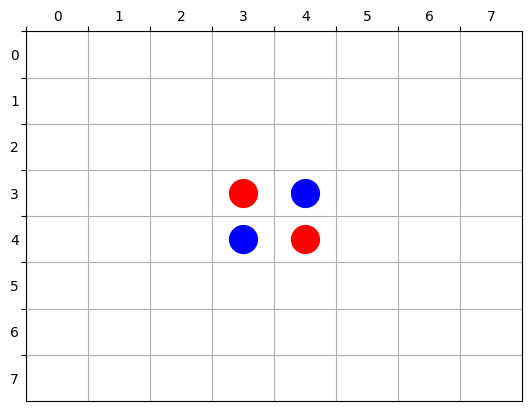

([4, 2], 1.7632432432432432)

In [116]:
A = init_plateau()
tracerPlateau(A)
alpha_beta(A, 1, 5, score_method1=score_lda1, score_method2=score_lda2)

Le résultat : 60 --- 3 


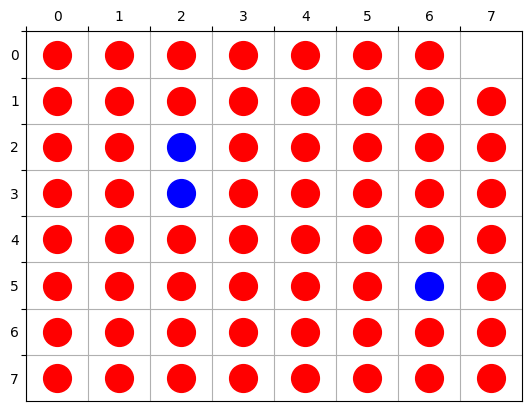

In [117]:
def game_auto_minmax_alpha_beta_lda(A, c, depth=5):
    while not game_finish(A):
        possible_steps, possible_steps_changes = find_possible_steps(A, c)
        
        if c == 1:
            if possible_steps:
                step = alpha_beta(A, 1, 5, score_method1=score_lda1, score_method2=score_lda2)[0]
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        if c == -1:
            if possible_steps:
                step = random.choice(possible_steps)
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        c = -c
    
    return A

print_info(game_auto_minmax_alpha_beta_lda(init_plateau(), 1, depth=5))

In [101]:
win_time = 0

for fois in range(50):
    if fois % 20 == 0:
        print(f"Nous avons fait {fois}/100 fois.")
    A = game_auto_minmax_alpha_beta_lda(init_plateau(), 1, depth=5)
    if score(A) > 0 :
        win_time += 1

print(f"Le taux de victoire est {win_time} / 50.")

Nous avons fait 0/100 fois.
Nous avons fait 20/100 fois.
Nous avons fait 40/100 fois.
Le taux de victoire est 42 / 50.


@# r2q3r 32

Le résultat : 33 --- 31 


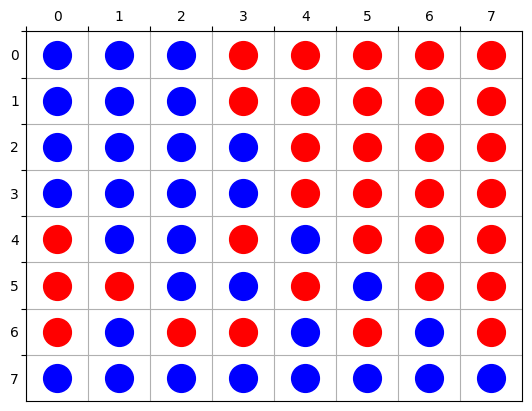

In [118]:
A = init_plateau(); c=1

def game_auto_test1(A, c, depth=5):
    while not game_finish(A):
        possible_steps, possible_steps_changes = find_possible_steps(A, c)
        
        if c == 1:
            if possible_steps:
                step = alpha_beta(A, 1, 5, score_method1=score_lda1, score_method2=score_lda2)[0]
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        if c == -1:
            if possible_steps:
                step = alpha_beta(A, -1, 5)[0]
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        c = -c
    
    return A

print_info(game_auto_test1(A, c, depth=5))

Le résultat : 33 --- 31 


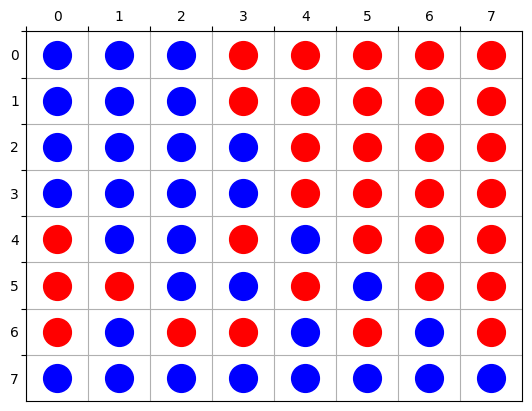

In [119]:
A = init_plateau(); c=1;

def game_auto_test1(A, c, depth=5):
    while not game_finish(A):
        possible_steps, possible_steps_changes = find_possible_steps(A, c)
        
        if c == 1:
            if possible_steps:
                step = alpha_beta(A, 1, 5)[0]
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        if c == -1:
            if possible_steps:
                step = alpha_beta(A, -1, 5, score_method1=score_lda1, score_metho2d2=score_lda2)[0]
                A = update(A, c, step, possible_steps_changes[possible_steps.index(step)])
                plt.show()
        c = -c
    
    return A

print_info(game_auto_test1(A, c, depth=5))

## 1111 

In [ ]:
def Play(depth=6):

    A = init_plateau()

    Game_mode = int(input('Choisissez votre couleur: Rouge[1] ou Bleu[-1]'))

    if Game_mode == -1:
        print('Votre couleur: Bleu  Étapes possibles: Les étoiles')
        
        while not game_finish(A):
            possible_steps1, possible_steps_changes1 = find_possible_steps(A, 1)

            if possible_steps1:
                step = alpha_beta(A, 1, depth)[0]
                A = update(A, 1, step, possible_steps_changes1[possible_steps1.index(step)])
            
            possible_steps2, possible_steps_changes2 = find_possible_steps(A, -1)
            
            if possible_steps2:

                tracerPlateau(A, possible_steps2)
                plt.show()
                user_step = input('Choisir votre étape'+str(possible_steps2)+':')
                User_step = possible_steps2[int(user_step)-1]
                A = update(A, -1, User_step, possible_steps_changes2[possible_steps2.index(User_step)])
                tracerPlateau(A)
                plt.show()

    if Game_mode == 1:
        print('Votre couleur: Rouge  Étapes possibles: Les étoiles')
            
        while not game_finish(A):       
            possible_steps1, possible_steps_changes1 = find_possible_steps(A, 1)
            
            if possible_steps1:

                tracerPlateau(A, possible_steps1)
                plt.show()
                user_step = input('Choisir votre étape'+str(possible_steps1)+':')
                User_step = possible_steps1[int(user_step)-1]
                A = update(A, 1, User_step, possible_steps_changes1[possible_steps1.index(User_step)])
                tracerPlateau(A)
                plt.show()

            possible_steps2, possible_steps_changes2 = find_possible_steps(A, -1)

            if possible_steps2:
                step = alpha_beta(A, -1, depth)[0]
                A = update(A, -1, step, possible_steps_changes2[possible_steps2.index(step)])
    tracerPlateau(A)
    plt.show()                
    if np.sum(A == 1) > np.sum(A == -1):       
        print("Le résultat, Rouge gagne : {} --- {} ".format(np.sum(A == 1), np.sum(A == -1)))
    if np.sum(A == 1) < np.sum(A == -1): 
        print("Le résultat, Bleu gagne : {} --- {} ".format(np.sum(A == 1), np.sum(A == -1)))        
    if np.sum(A == 1) == np.sum(A == -1): 
        print("Le résultat, Match nul : {} --- {} ".format(np.sum(A == 1), np.sum(A == -1)))        
Play(depth=6)

ValueError: invalid literal for int() with base 10: ''